<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Подготовка" data-toc-modified-id="1.-Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>1. Подготовка</a></span></li><li><span><a href="#2.-Обучение" data-toc-modified-id="2.-Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>2. Обучение</a></span><ul class="toc-item"><li><span><a href="#Обучим-3-модели" data-toc-modified-id="Обучим-3-модели-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Обучим 3 модели</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## 1. Подготовка

Импортируем библиотеки и познакомимся с данными

In [1]:
!pip install -q nltk

In [2]:
import pandas as pd
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.pipeline import Pipeline
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns 
import lightgbm as lgb
from sklearn.metrics import f1_score, make_scorer
from tqdm.notebook import tqdm
tqdm.pandas()

C:\Users\anon9\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anon9\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\anon9\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
df = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Избавимся от лишнего столбца при выгрузке данных

In [5]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


првоерим дубликаты, пропусоков нет, это виднго из `info`

In [6]:
df.duplicated().sum()

0

Создаем функцию лемматизации и подчищаем тескт

In [7]:

def lemmatize_df(text):
    text = text.lower()
    clear_text = re.sub(r'[^a-zA-Z]', ' ', text)
    return " ".join(clear_text.split())

df['text'] = df['text'].apply(lemmatize_df)

In [8]:
df.head()

,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he matches this background colour i m se...,0
2,hey man i m really not trying to edit war it s...,0
3,more i can t make any real suggestions on impr...,0
4,you sir are my hero any chance you remember wh...,0


In [9]:
%%time

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,               
                "N": wordnet.NOUN,              
                "V": wordnet.VERB,              
                "R": wordnet.ADV                
               }  
    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()

def lemm_text(text):
    text = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
    return ' '.join(text)

 

Wall time: 0 ns


In [10]:
%%time

df['text'] = df['text'].progress_apply(lemm_text)

  0%|          | 0/159292 [00:00<?, ?it/s]

Wall time: 1h 42min 36s


In [12]:
df.head(10)

,text,toxic
0,explanation why the edits make under my userna...,0
1,d aww he match this background colour i m seem...,0
2,hey man i m really not try to edit war it s ju...,0
3,more i can t make any real suggestion on impro...,0
4,you sir be my hero any chance you remember wha...,0
5,congratulation from me a well use the tool wel...,0
6,cocksucker before you piss around on my work,1
7,your vandalism to the matt shirvington article...,0
8,sorry if the word nonsense be offensive to you...,0
9,alignment on this subject and which be contrar...,0


Супер, все почистилось, далее удалим столбец с неподчищенным текстом 

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Проверим данные на дисбпланс

0    143106
1     16186
Name: toxic, dtype: int64


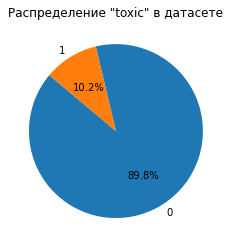

In [14]:
toxic_counts = (df['toxic'].value_counts())
plt.pie(toxic_counts, labels=toxic_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Распределение "toxic" в датасете');
print(df['toxic'].value_counts())

Будем в модели использовать баланс, указывать параметр

## 2. Обучение

Выделим фичи и целевой признак  
Так же разделим данные на выборки

In [15]:
target = df['toxic']
features = df.drop(['toxic'], axis=1)

In [16]:
%%time


features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            test_size=0.1,
                                                                            random_state=12345)


nltk.download('stopwords')
stopwords_list = set(stopwords.words('english'))


print("Размер тренировочной выборки:", features_train.shape)
print("Размер тестовой выборки:", features_test.shape)

Размер тренировочной выборки: (143362, 1)
Размер тестовой выборки: (15930, 1)
Wall time: 253 ms


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anon9\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Обучим 3 модели 

LogisticRegression

In [22]:
%%time

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords_list)),
    ('classifier', LogisticRegression(class_weight='balanced'))
])

param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)], 
    'classifier__C': [0.1, 1, 10], 
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1')

grid_search.fit(features_train['text'], target_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_lr_f1_train = grid_search.best_score_

print("Лучшие параметры:", best_params)
print("F1-метрика на тренировочных  данных:", best_lr_f1_train)

C:\Users\anon9\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\anon9\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Лучшие параметры: {'classifier__C': 10, 'tfidf__ngram_range': (1, 2)}
F1-метрика на тренировочных  данных: 0.7790387356455555
Wall time: 7min 22s


CatBoost

In [18]:
%%time

tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords_list, ngram_range=(1, 1))

features_train_tfidf = tfidf_vectorizer.fit_transform(features_train['text'])
features_test_tfidf = tfidf_vectorizer.transform(features_test['text'])


catboost_classifier = CatBoostClassifier(class_weights=[1, 1], iterations=50)


param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
}

grid_search = GridSearchCV(catboost_classifier, param_grid, cv=3, scoring='f1', verbose=2)

grid_search.fit(features_train_tfidf, target_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_cb_f1_train = grid_search.best_score_

print("Лучшие параметры:", best_params)
print("F1-метрика на тренировочных данных:", best_cb_f1_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
0:	learn: 0.6827330	total: 747ms	remaining: 36.6s
1:	learn: 0.6723454	total: 1.31s	remaining: 31.5s
2:	learn: 0.6618170	total: 1.89s	remaining: 29.5s
3:	learn: 0.6514694	total: 2.46s	remaining: 28.3s
4:	learn: 0.6416251	total: 3.04s	remaining: 27.4s
5:	learn: 0.6319695	total: 3.6s	remaining: 26.4s
6:	learn: 0.6228031	total: 4.17s	remaining: 25.6s
7:	learn: 0.6137664	total: 4.73s	remaining: 24.8s
8:	learn: 0.6051267	total: 5.3s	remaining: 24.2s
9:	learn: 0.5967318	total: 5.87s	remaining: 23.5s
10:	learn: 0.5881397	total: 6.44s	remaining: 22.8s
11:	learn: 0.5793694	total: 7.03s	remaining: 22.3s
12:	learn: 0.5710639	total: 7.62s	remaining: 21.7s
13:	learn: 0.5634120	total: 8.22s	remaining: 21.1s
14:	learn: 0.5557311	total: 8.83s	remaining: 20.6s
15:	learn: 0.5480815	total: 9.48s	remaining: 20.2s
16:	learn: 0.5406133	total: 10.2s	remaining: 19.8s
17:	learn: 0.5334438	total: 10.9s	remaining: 19.3s
18:	learn: 0.5266132	total: 11.5s	r

LGBMClassifier

In [19]:
%%time

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords_list, ngram_range=(1, 1))), 
    ('classifier', LGBMClassifier(class_weight='balanced', n_estimators=5))
])

param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],  
    'classifier__learning_rate': [0.01, 0.1, 0.2], 
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1', verbose=2)  

grid_search.fit(features_train['text'], target_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_lgbm_f1_train = grid_search.best_score_

print("Лучшие параметры:", best_params)
print("F1-метрика на тестовых данных:", best_lgbm_f1_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END classifier__learning_rate=0.01, tfidf__ngram_range=(1, 1); total time=   9.0s
[CV] END classifier__learning_rate=0.01, tfidf__ngram_range=(1, 1); total time=   9.0s
[CV] END classifier__learning_rate=0.01, tfidf__ngram_range=(1, 1); total time=   8.9s
[CV] END classifier__learning_rate=0.01, tfidf__ngram_range=(1, 2); total time=  28.6s
[CV] END classifier__learning_rate=0.01, tfidf__ngram_range=(1, 2); total time=  28.4s
[CV] END classifier__learning_rate=0.01, tfidf__ngram_range=(1, 2); total time=  28.6s
[CV] END classifier__learning_rate=0.1, tfidf__ngram_range=(1, 1); total time=   9.4s
[CV] END classifier__learning_rate=0.1, tfidf__ngram_range=(1, 1); total time=   9.9s
[CV] END classifier__learning_rate=0.1, tfidf__ngram_range=(1, 1); total time=   9.7s
[CV] END classifier__learning_rate=0.1, tfidf__ngram_range=(1, 2); total time=  30.8s
[CV] END classifier__learning_rate=0.1, tfidf__ngram_range=(1, 2); total t

Посмотрим на все результаты

In [25]:
print("F1-метрика на тренировочных  данных:", best_lr_f1_train)
print("F1-метрика CatBoostClassifier на тренировочных данных:", best_cb_f1_train)
print("F1-метрика LGBMClassifier на тренировочных данных:", best_lgbm_f1_train)

F1-метрика на тренировочных  данных: 0.7790387356455555
F1-метрика CatBoostClassifier на тренировочных данных: 0.6490579151878711
F1-метрика LGBMClassifier на тренировочных данных: 0.6677268319279236


Лучший результат показывает модель `Logistic Regression`

Результат модели на тестовых данных

In [34]:
best_model = grid_search.best_estimator_

predicted_test = best_model.predict(features_test['text'])

f1_test = f1_score(target_test, predicted_test)

print("F1-метрика на тестовых данных:", f1_test)

F1-метрика на тестовых данных: 0.7889630078835658


## Вывод


Рекомендую для предсказания точкисности комментариев использовать модель Логистической регрессии, по скольку она показывает лучший результат f1